# Exploration of Passes and Shots rate

Wyscout public Event Data will be used in this work. It will be first converted into SPALD representation so that it can be easier to manage.

The plots code were adapted from https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking.

In [131]:
import os
import warnings
import tqdm
import pandas as pd
import numpy as np
from colour import Color

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import matplotlib.pyplot as plt
from io import BytesIO
from pathlib import Path

from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve

from socceraction.spadl.wyscout import convert_to_spadl
import LaurieOnTracking_SourceCode.Metrica_Viz as mviz

pd.options.mode.chained_assignment = None
plt.style.use(['ggplot'])


## Load Data and Store in SPADL representation

Wyscout public data will be used (https://figshare.com/collections/Soccer_match_event_dataset/4415000).


In [2]:
#Code adapted from https://github.com/SciSports-Labs/fot-valuing-actions/blob/master/notebooks/tutorial1-run-pipeline.ipynb


def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

    
#Convert Teams data
json_teams = read_json_file('LaLiga_data/teams.json')
df_teams = pd.read_json(json_teams)
df_teams.to_hdf('wyscout.h5', key='teams', mode='w')


#Convert Players data
json_players = read_json_file('LaLiga_data/players.json')
df_players = pd.read_json(json_players)
df_players.to_hdf('wyscout.h5', key='players', mode='a')


competition = 'Spain'


#Convert Matches data
file_matches = f'LaLiga_data/matches_{competition}.json'
json_matches = read_json_file(file_matches)

df_matches = pd.read_json(json_matches)
df_matches.to_hdf('wyscout.h5', key='matches', mode='a')


#Convert Events data
file_events = f'LaLiga_data/events_{competition}.json'
json_events = read_json_file(file_events)
df_events = pd.read_json(json_events)
df_events_matches = df_events.groupby('matchId', as_index=False)
for match_id, df_events_match in df_events_matches:
    df_events_match.to_hdf('wyscout.h5', key=f'events/match_{match_id}', mode='a')

convert_to_spadl('wyscout.h5', 'LaLiga_data/spadl.h5')


  0%|          | 0/380 [00:00<?, ?game/s]

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


  0%|          | 0/380 [00:00<?, ?game/s]

...Converting events to actions


100%|██████████| 380/380 [06:39<00:00,  1.05s/game]


## Load Spadl data

In [2]:
df_games = pd.read_hdf('LaLiga_data/spadl.h5', key='games')
df_players = pd.read_hdf('LaLiga_data/spadl.h5', key='players')
df_teams = pd.read_hdf('LaLiga_data/spadl.h5', key='teams')
df_players_games = pd.read_hdf('LaLiga_data/spadl.h5', key='player_games')
df_results = pd.read_hdf('LaLiga_data/spadl.h5', key='results')
df_actiontypes = pd.read_hdf('LaLiga_data/spadl.h5', key='actiontypes')

dfs_events = []
#load feaures for a dataframe
for _, game in df_games.iterrows():
    game_id = game['game_id']
    
    #load all features for all actions of given game
    df_ev = pd.read_hdf('LaLiga_data/spadl.h5', key=f'actions/game_{game_id}')
    df_ev['game_id'] = game_id
    dfs_events.append(df_ev)
    
#create df_features (for all actions)
dfs_events = pd.concat(dfs_events).reset_index(drop=True)
dfs_events = dfs_events.sort_values(by=["game_id", "period_id", "time_seconds"])

In [293]:
display(dfs_events.head())
dfs_events.shape

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id
463744,2565548,1.0,2.994582,682.0,3542.0,66.15,41.48,52.50,34.00,0,0,1
463745,2565548,1.0,3.137020,682.0,274435.0,52.50,34.00,57.75,20.40,0,0,1
463746,2565548,1.0,6.709668,682.0,364860.0,57.75,20.40,65.10,8.16,0,0,1
463747,2565548,1.0,8.805497,682.0,3534.0,65.10,8.16,71.40,46.92,0,0,1
463748,2565548,1.0,14.047492,682.0,3695.0,71.40,46.92,72.45,25.16,0,0,1


(474875, 12)

## Plot the goal move

In [78]:
def convert_to_format(t_df):

    #rename some columns
    t_df = t_df.rename(columns={'start_x': 'Start X', 
                                'start_y': 'Start Y', 
                                'end_x': 'End X', 
                                'end_y': 'End Y',
                                'player_name': 'From',
                                'type_id': 'Type'})

    t_df['From'] = t_df['From'].astype(str)

    
    #resize X and Y positions
    dim = (105, 68)

    for c in ['Start X', 'Start Y', 'End X', 'End Y']:
        if c in ['Start X', 'End X']:
            t_df[c] = t_df[c] - dim[0]/2

        elif c in ['Start Y', 'End Y']:
            t_df[c] = (t_df[c])  - dim[1]/2

    t_df.reset_index(inplace = True, drop = True)

    return t_df


def plot_actions(t_df, colors):
    
    
    markers = ['o' if i == True else '+' for i in t_df['Type'] == 0]
    alphas = [1.0 if i == True else 0.1 for i in t_df['Type'] == 0]

    mviz.my_plot_events( t_df, 
                        indicators = ['Marker','Arrow'], 
                        annotate=True , marker_style = markers, alpha = alphas, 
                        field_dimen = (105,68), colors = colors)
    plt.show()
    

def get_play_of_goal(df, ind):
    counter = 1
    initial_play = ind
    while(ind - counter > 0 and df.loc[ind - counter, 'type_id'] == 0):
        initial_play -= 1
        counter += 1
        
    return df.loc[initial_play:ind, :]

def add_players_names(df):
    players_names = []
    for ind, row in df.iterrows():
        n = df_players[df_players.player_id == row['player_id']].iloc[0]['short_name']
        players_names.append(n) 

    df.loc[:, 'player_name'] = players_names
    return df

In [79]:
#find el clasico game

real_id = df_teams[df_teams['short_team_name'] == 'Real Madrid'].iloc[0]['team_id']
barca_id = df_teams[df_teams['short_team_name'] == 'Barcelona'].iloc[0]['team_id']

el_clasico_id = df_games[(df_games['away_team_id'] == barca_id) & (df_games['home_team_id'] == real_id)].iloc[0]['game_id']

df_match = dfs_events[dfs_events['game_id'] == el_clasico_id]


### Plot first Goal

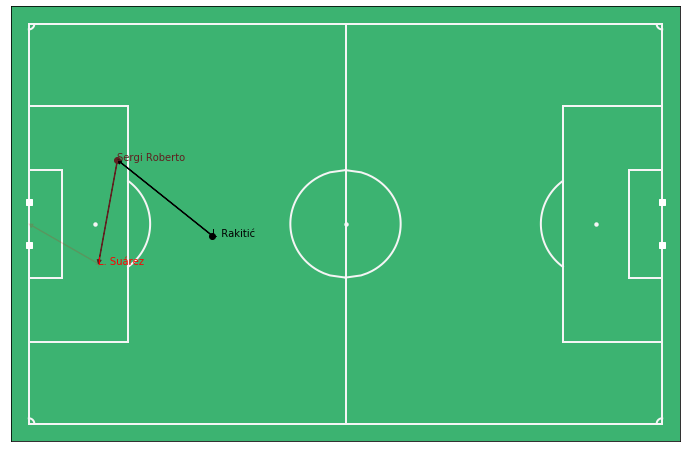

In [80]:
#find events that lead to goal
#11: shot, 12: penalty
goals_df = df_match[(df_match['type_id'].isin([11, 12])) & (df_match['result_id'] == 1)]

#first_goal
goal_ind = 0
play_df = get_play_of_goal(df_match, goals_df.iloc[goal_ind].name)
play_df = add_players_names(play_df)
play_df = convert_to_format(play_df)

colors = list(Color("black").range_to(Color("red"),len(play_df)))
colors = [c.rgb for c in colors]

plot_actions(play_df, colors)

### Plot all shots

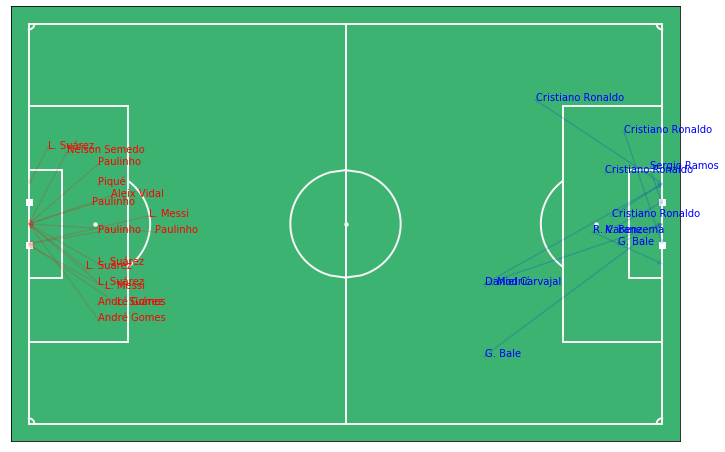

In [82]:
#all shots

play_df = df_match[(df_match['type_id'].isin([11]))]

#goal_ind = 0
#play_df = get_play_of_goal(df_match, goals_df.iloc[goal_ind].name)

play_df = add_players_names(play_df)
play_df = convert_to_format(play_df)

colors = []
for i in play_df['team_id'].values:
    if i == barca_id:
        colors.append('red')
    else:
        colors.append('blue')

plot_actions(play_df, colors)

## Analysis of the evolution of a particlar player over time (L. Messi)

Minutes played, pass accuracy and goals rate will be analysed

In [295]:
#player id
p_id = df_players[df_players['short_name'] == 'L. Messi'].iloc[0].player_id

#find_team
t_id = int(df_players_games[df_players_games.player_id == p_id].iloc[0]['team_id'])


#all Barça games
all_games = df_games[(df_games['home_team_id'] == t_id) | (df_games['away_team_id'] == t_id)].sort_values(by='game_id')


#all Player games
p_games = df_players_games[df_players_games.player_id == p_id].sort_values(by='game_id')



### Player Minutes distribution

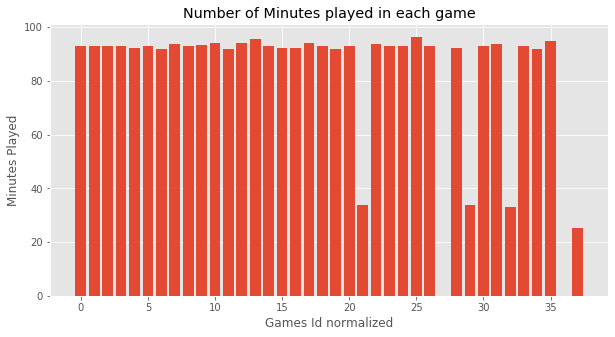

In [331]:
g_inds = all_games.game_id.values.tolist()
p_inds = [g_inds.index(i) for i in p_games.game_id]

p_games['normalized_ind'] = p_inds


plt.figure(figsize = (10, 5))
plt.bar(p_games.normalized_ind, p_games.minutes_played)
plt.xlabel('Games Id normalized')
plt.ylabel('Minutes Played')
plt.title('Number of Minutes played in each game')
plt.show()

As can be seen, Messi participates almost in every game, during the 90 miutes

### Pass Accuracy of L. Messi

In [297]:
p_events = dfs_events[(dfs_events['player_id'] == p_id) & (dfs_events['type_id'] == 0)]


df_passes = p_events.groupby(['game_id', 'result_id']).size()
df_passes = pd.DataFrame(df_passes, columns=['counts'])
df_passes.reset_index(inplace=True)

#number of sucessfull and unsucessfull passes
df_passes.head()

,game_id,result_id,counts
0,2565554,0,5
1,2565554,1,53
2,2565559,0,8
3,2565559,1,55
4,2565577,0,7


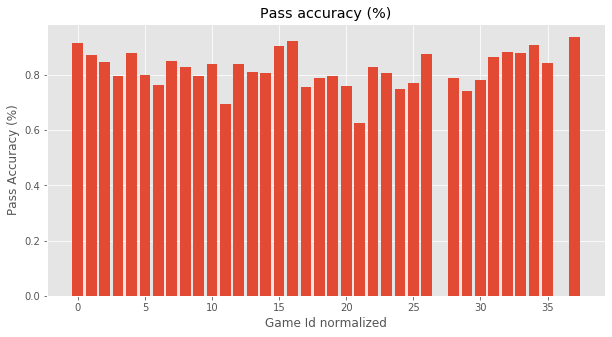

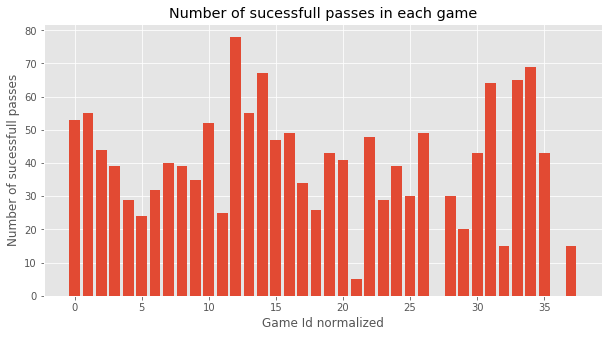

In [334]:
#normalize game id, with a simple counter
p_inds = [g_inds.index(row.game_id) for i, row in df_passes.iterrows()]
df_passes['normalized_ind'] = p_inds

#compute the percentage of sucessfull and unsucessfull passes
perc_passes = []
for ind, row in df_passes.iterrows():
    perc_passes.append(row['counts']/df_passes[df_passes.game_id == row.game_id]['counts'].sum())

df_passes['perc_passes'] = perc_passes

suc_passes = df_passes[df_passes['result_id'] == 1]
unsuc_passes = df_passes[df_passes['result_id'] == 0]

plt.figure(figsize = (10, 5))
plt.bar(suc_passes.normalized_ind, suc_passes.perc_passes)
plt.xlabel('Game Id normalized')
plt.ylabel('Pass Accuracy (%)')
plt.title('Pass accuracy (%)')
plt.show()

plt.figure(figsize = (10, 5))
plt.bar(suc_passes.normalized_ind, suc_passes.counts)
plt.xlabel('Game Id normalized')
plt.ylabel('Number of successfull passes')
plt.title('Number of successfull passes in each game')
plt.show()

As illustrated in the graphs above the number of Messi successfull passes in each game is, in average, 40.6 with an accuracy rate of 82%

### Number of shots

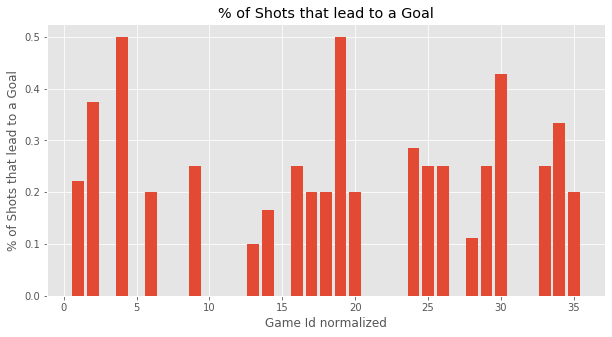

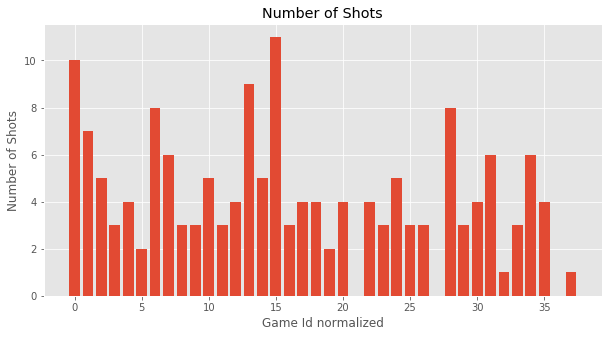

In [329]:
p_shots = dfs_events[(dfs_events['player_id'] == p_id) & (dfs_events['type_id'].isin([11, 12, 13]) )]

df_shots = p_shots.groupby(['game_id', 'result_id']).size()
df_shots = pd.DataFrame(df_shots, columns=['counts'])
df_shots.reset_index(inplace=True)

#normalize game id, with a simple counter
p_inds = [g_inds.index(row.game_id) for i, row in df_shots.iterrows()]
df_shots['normalized_ind'] = p_inds

#compute the percentage of sucessfull and unsucessfull passes
perc_shots = []
for ind, row in df_shots.iterrows():
    perc_shots.append(row['counts']/df_shots[df_shots.game_id == row.game_id]['counts'].sum())

df_shots['perc_shots'] = perc_shots

suc_shots = df_shots[df_shots['result_id'] == 1]
unsuc_shots = df_shots[df_shots['result_id'] == 0]


plt.figure(figsize = (10, 5))
plt.bar(suc_shots.normalized_ind, suc_shots.perc_shots)
plt.xlabel('Game Id normalized')
plt.ylabel('% of Shots that lead to a Goal')
plt.title('% of Shots that lead to a Goal')
plt.show()


plt.figure(figsize = (10, 5))
plt.bar(df_shots.normalized_ind, df_shots.counts)
plt.xlabel('Game Id normalized')
plt.ylabel('Number of Shots')
plt.title('Number of Shots')
plt.show()


The number of shots of Mess, per game, is, on average, 3.4 with a probabilty of scoring around 26%.